In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from functools import lru_cache
import pickle
from tqdm.notebook import trange
path="/content/drive/MyDrive/Digest/"


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers  import Layer,LayerNormalization,Embedding,Dropout
from tensorflow.keras.layers  import Dense as Linear
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy 



In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
dataset=pd.read_excel("/content/drive/MyDrive/Digest/Inshorts.xlsx")
print(dataset.shape)
news=dataset["Short"].tolist()
summ=dataset["Headline"].tolist()
dataset.head(10)


(55104, 5)


,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25
5,New trailer of &#39;Justice League&#39; released,A new trailer for the upcoming superhero film ...,YouTube,21:50:00,2017-03-25
6,His touch was not right: Shilpa Shinde on sexu...,"Television actress Shilpa Shinde, while openin...",The Quint,21:18:00,2017-03-25
7,Anti-Romeo squads must not trouble consenting ...,"Uttar Pradesh Chief Minister Yogi Adityanath, ...",ANI,23:05:00,2017-03-25
8,Both Romeo and Juliet are welcome in Delhi: AA...,In an apparent jibe at UP&#39;s anti-Romeo squ...,India Today,09:26:00,2017-03-26
9,"30 blasts occur at ordnance factory in MP, 20...",At least 20 people were reportedly injured aft...,Hindustan Times,21:24:00,2017-03-25


In [ ]:
dataset=pd.read_csv("/content/drive/MyDrive/Digest/news_summary.csv")
print(dataset.shape)
news.extend(dataset["text"].tolist())
summ.extend(dataset["headlines"].tolist())

(98401, 2)


In [ ]:
dataset_news=news
dataset_summ=summ

In [ ]:
print(dataset_news[5],'\n',dataset_summ[5])

A new trailer for the upcoming superhero film &#39;Justice League&#39; was released on Saturday. Based on the DC Comics superhero team, the film stars Ben Affleck as &#39;Batman&#39;, Gal Gadot as &#39;Wonder Woman&#39;, Ezra Miller as &#39;The Flash&#39; and Jason Momoa as &#39;Aquaman&#39;. Directed by Zack Snyder, the film is scheduled to release on November 17, 2017. 
 New trailer of &#39;Justice League&#39; released


In [ ]:
# preprocessing
import re
def process_sentence(sent):
    x=sent
    x=x.lower()
    x=x.replace('&#39;','')# due to bug in dataset
    x= re.sub(r"\([^()]*\)", "",x)
    x=re.sub("""[^A-Za-z0-9.,: ]+""",' ',x)
    x=' '.join(x.split())
    x='summstart '+x+' summend'
    return x
no_samples=len(dataset_news)
for i in range(no_samples):

  dataset_news[i]=process_sentence(dataset_news[i])
  dataset_summ[i]=process_sentence(dataset_summ[i])



In [ ]:
print(dataset_news[52],'\n',dataset_summ[52])

summstart the smell of freshly cut grass is a distress call released by chemical compounds present in the grass. the smell, induced by a compound called green leaf volatiles, seeks to notify nearby plants to rescue them from the attack. the release of other compounds in similar situations help in the formation of new cells and prevention of bacterial or fungal infection. summend 
 summstart plants let out a cry for help when cut summend


In [ ]:
def pad_sequences(text,padding):
    max_len=max([len(i) for i in text])
    pad_Seq=[]
    if(padding=='post'):
       for sent in text:
           s=[0 for i in range(max_len)]
           s[:len(sent)]=sent
           pad_Seq.append(s)
    else :
        for sent in text:
           s=[0 for i in range(max_len)]
           s[:len(sent)]=sent[::-1]
           pad_Seq.append(s[::-1])
        
    return max_len,np.array((pad_Seq))

In [ ]:

"""
#tokeisation -> converting the sentence to tokens


#source-> news
#target-> summary

#source

source_tokenizer=Tokenizer()
source_tokenizer.fit_on_texts(dataset_news)
source_tensor=source_tokenizer.texts_to_sequences(dataset_news)
max_source_length,source_tensor= pad_sequences(source_tensor,padding='post')

#target
target_tokenizer=Tokenizer()
target_tokenizer.fit_on_texts(dataset_summ)
target_tensor=target_tokenizer.texts_to_sequences(dataset_summ)
max_target_length,target_tensor= pad_sequences(target_tensor,padding='post')
"""

"\n#tokeisation -> converting the sentence to tokens\n\n\n#source-> news\n#target-> summary\n\n#source\n\nsource_tokenizer=Tokenizer()\nsource_tokenizer.fit_on_texts(dataset_news)\nsource_tensor=source_tokenizer.texts_to_sequences(dataset_news)\nmax_source_length,source_tensor= pad_sequences(source_tensor,padding='post')\n\n#target\ntarget_tokenizer=Tokenizer()\ntarget_tokenizer.fit_on_texts(dataset_summ)\ntarget_tensor=target_tokenizer.texts_to_sequences(dataset_summ)\nmax_target_length,target_tensor= pad_sequences(target_tensor,padding='post')\n"

In [ ]:
#source

with open(path+'sourcetokenizer.pickle', 'rb') as handle:
    source_tokenizer = pickle.load(handle)
source_tensor=source_tokenizer.texts_to_sequences(dataset_news)
max_source_length,source_tensor= pad_sequences(source_tensor,padding='post')

#target
with open(path+'targettokenizer.pickle', 'rb') as handle:
    target_tokenizer = pickle.load(handle)
target_tensor=target_tokenizer.texts_to_sequences(dataset_summ)
max_target_length,target_tensor= pad_sequences(target_tensor,padding='post')

In [ ]:
# saving

"""
with open(path+'sourcetokenizer.pickle', 'wb') as handle:
    pickle.dump(source_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path+'targettokenizer.pickle', 'wb') as handle:
    pickle.dump(target_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) """
    
       

"\nwith open(path+'sourcetokenizer.pickle', 'wb') as handle:\n    pickle.dump(source_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)\nwith open(path+'targettokenizer.pickle', 'wb') as handle:\n    pickle.dump(target_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) "

In [ ]:
print(source_tensor[0])
print(target_tensor[0])


[    7     1   714     9   141  1422   153    89   162     5 14022   203
     6   215   327    10  3197 15805  1358  3286     6  1936 13714    60
   758     2     1    71   304   203     1   142    32 11340   235  1379
     6  1603    21 14022   203     9     1  1666     5  7332     6 10481
  1481   376  1022    39 12222  3010     2     1   461   861    17     1
   142  1877     8     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
[    1    65    62   139   699   568     5  1909   139     7 17317    35
     2     0     0     0     0     0     0     0]


In [ ]:
vocab_size_source=len(source_tokenizer.word_index)+1 # one for the padding of zeros
vocab_size_target=len(target_tokenizer.word_index)+1

In [ ]:
encoder_config={"vocab_Size":vocab_size_source,"max_len":max_source_length}
decoder_config={"vocab_Size":vocab_size_target,"max_len":max_target_length}

In [ ]:
max_source_length

79


**Model**








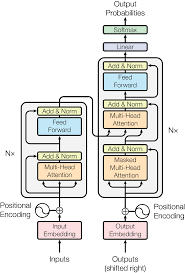

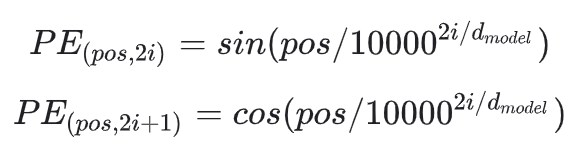

In [ ]:
# positional encodings
"""
since transformers cannot handle positions as lstm/rnn dowe need to insert some other paramter for it
so using positional encoding which is like a sinusoidal wave like alternating bits indicating positions

row ->pos
col ->dim
       0                        1                        2                        3                        4 
  
0     s(0/10K^(2*0/dmodel))   c(0/10K^(2*[1-1]/dmodel)) s(0/10K^(2*1/dmodel))  c(0/10K^(2*[2-1]/dmodel))

1   s(1/10K^(2*0/dmodel))   c(1/10K^(2*[1-1]/dmodel)) s(1/10K^(2*1/dmodel))  c(1/10K^(2*[2-1]/dmodel))


"""
def Positional_Encoding(length,model_dimension):
  
  md=model_dimension
  array=np.zeros((length,md))
  for pos in range(length):
    for i in range(md):
      if (i%2==0):
        array[pos][i]=np.sin(pos/np.power(10000,i/np.float32(md)))
      else:
        array[pos][i]=np.cos(pos/np.power(10000,(i-1)/np.float32(md)))

  return tf.cast(array ,dtype=tf.float32)     #torch.tensor 





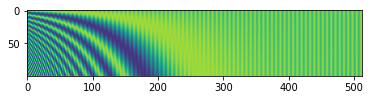

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(Positional_Encoding(100,512))

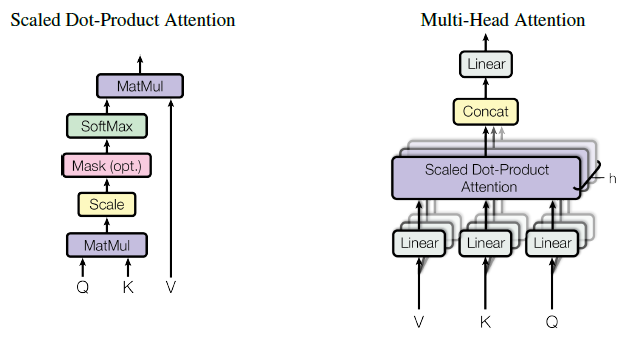

In [ ]:
@lru_cache(None)
def masking(seq_len):
  # while training the decoder part it sould train without focusing on future predictions
  # bcz its work is to find future word with the help of prev words
  # so giving acces to future world has no logic on decoder

  # the score matrix is in shape query x query of decoder input
  # the scores of future words should be zero after softmax should be zero 

  """
    tf.linalg.band_part(input, 0, -1) ==> Upper triangular part.
    tf.linalg.band_part(input, -1, 0) ==> Lower triangular part.
    tf.linalg.band_part(input, 0, 0) ==> Diagonal.
  """

  return 1-tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

In [ ]:
masking(10)

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
class Attention(Layer):
  def __init__(self,dimension,num_heads):

    super().__init__()

    assert(dimension%num_heads==0 )
    self.num_heads=num_heads
    self.vec_dim=dimension//num_heads 
    self.scaling = tf.math.sqrt(tf.cast(self.vec_dim,dtype=tf.float32))

    # projection are the weights
   
    self.q_proj =Linear(dimension)
    self.k_proj =Linear(dimension)
    self.v_proj =Linear(dimension)

    self.out_proj=Linear(dimension)

  def split_heads(self,tensor):

    bz,seqlen,dimension=tensor.shape
    assert(self.vec_dim*self.num_heads==dimension)
    tensor=tf.reshape(tensor,(bz,seqlen,self.num_heads,self.vec_dim))
    tensor=tf.transpose(tensor,perm=[0,2,1,3])
    tensor=tf.reshape(tensor,(bz*self.num_heads,seqlen,self.vec_dim))

    return tensor

  def concat_heads(self,tensor):

    bz_x_nohead,seqlen,vec_dim=tensor.shape
    assert(vec_dim==self.vec_dim)
    assert(bz_x_nohead%self.num_heads==0)
    bz= bz_x_nohead//self.num_heads
    tensor=tf.reshape(tensor,(bz,self.num_heads,seqlen,vec_dim))
    tensor=tf.transpose(tensor,perm=[0,2,1,3])
    tensor=tf.reshape(tensor,(bz,seqlen,self.num_heads*vec_dim))
    return tensor
  # writing code in common for all varieties of attention =>(encoder,decoder,masked)  
  def call(self,query,key,value,mask=False):


    query_states=self.q_proj(query)
    
    key_states = self.k_proj(key)
    value_states = self.v_proj(value)

    query_states = self.split_heads(query_states)
    key_states =   self.split_heads(key_states)
    value_states = self.split_heads(value_states)

    # scaled dot product attention
    #print(query_states.shape,tf.transpose(key_states,perm=[0,2,1]).shape)
    attn_weights = tf.matmul(query_states,tf.transpose(key_states,perm=[0,2,1]))/self.scaling

    if(mask):
      seqlen=query.shape[-2]
      attn_weights += ( masking(seqlen)*-1e9 )
 
    attn_probs = softmax(attn_weights, axis=-1)  
    attn_out = tf.matmul(attn_probs,value_states)
    attn_out = self.concat_heads(attn_out)

    attn_output = self.out_proj(attn_out)
    
    return attn_output



In [ ]:
a=Attention(16,2)
zz=np.random.randint(10, size=(1,7,16))
zz=tf.cast(zz,dtype=tf.float32)
z=a(zz,zz,zz,mask=True)
print(z.shape,zz.shape)

(1, 7, 16) (1, 7, 16)


In [ ]:
class Feed_Forward(Layer):
  def __init__(self,dimension,intermediate_size):
    super().__init__()
   
    self.intermediate_dense=Linear(intermediate_size,activation='relu')
    self.output_dense=Linear(dimension)

  def call(self,X):

    y=self.intermediate_dense(X)
    y=self.output_dense(y)
    
    return y


In [ ]:
class Encoder_block(Layer):
  def __init__(self,config):

    super().__init__()
    self.multiheadattn=Attention(config.dimension,config.no_heads)
    self.FFn=Feed_Forward(config.dimension,config.intermediate_size)

    self.layer_norm1 = LayerNormalization(epsilon=config.normeps)
    self.layer_norm2 = LayerNormalization(epsilon=config.normeps)

  def call(self,X,training=True):

    y=self.multiheadattn(X,X,X)
    y=self.layer_norm1(X+y)

    y1=self.FFn(y)
    y1=self.layer_norm2(y+y1)

    return y1

In [ ]:
class Decoder_block(Layer):
  def __init__(self,config):

    super().__init__()

    self.multiheadattn=Attention(config.dimension,config.no_heads)
    self.maskedattn=Attention(config.dimension,config.no_heads)
    self.FFn=Feed_Forward(config.dimension,config.intermediate_size)

    self.layer_norm1 = LayerNormalization(epsilon=config.normeps)
    self.layer_norm2 = LayerNormalization(epsilon=config.normeps)
    self.layer_norm3 = LayerNormalization(epsilon=config.normeps)

  def call(self,X,encoder_op,training=True):

    y=self.maskedattn(X,X,X,mask=True)
    y=self.layer_norm1(X+y)

    y1=self.multiheadattn(y,encoder_op,encoder_op)
    y1=self.layer_norm2(y+y1)

    y2=self.FFn(y1)
    y2=self.layer_norm3(y2+y1)

    return y2

In [ ]:
class Encoder(Layer):

  def __init__(self,config,enc_cfg):
    super().__init__()

    self.num_layers=config.no_layers
    self.emb_scale=tf.cast(config.dimension,dtype=tf.float32)
    self.embedding=Embedding(enc_cfg['vocab_Size'],config.dimension)
    self.pos_enc=Positional_Encoding(enc_cfg['max_len'],config.dimension)
    self.pos_enc=tf.expand_dims(self.pos_enc,axis=0)
    self.no_layers=config.no_layers
    self.encoder_blocks = [Encoder_block(config) for _ in range(config.no_layers)]

    self.drop=Dropout(config.dropout)

  def call(self,X,training=True):
    y=self.embedding(X)
    y*=tf.math.sqrt(self.emb_scale)
    seqlen=X.shape[-1]
    y+=self.pos_enc[:,:seqlen,:]
    y=self.drop(y,training=training)
    for i in range(self.no_layers):
      y=self.encoder_blocks[i](y,training)
    
    return y  




In [ ]:
class Decoder(Layer):

  def __init__(self,config,dec_cfg):
    super().__init__()

    self.num_layers=config.no_layers
    self.emb_scale=tf.cast(config.dimension,dtype=tf.float32)
    self.embedding=Embedding(dec_cfg['vocab_Size'],config.dimension)
    self.pos_enc=Positional_Encoding(dec_cfg['max_len'],config.dimension)
    self.pos_enc=tf.expand_dims(self.pos_enc,axis=0)
    self.no_layers=config.no_layers

    self.decoder_blocks = [Decoder_block(config) for _ in range(config.no_layers)]

    self.drop=Dropout(config.dropout)

  def call(self,X,encoder_op,training=True):
    y=self.embedding(X)
    y*=tf.math.sqrt(self.emb_scale)
    seqlen=X.shape[-1]
    y+=self.pos_enc[:,:seqlen,:]
    y=self.drop(y,training=training)
    for i in range(self.no_layers):
      y=self.decoder_blocks[i](y,encoder_op,training)
    return y  


In [ ]:

class Transfomer(Layer):

  def __init__(self,config,enc_cfg,dec_cfg):
    super().__init__()

    self.encoder=Encoder(config,enc_cfg)
    self.decoder=Decoder(config,dec_cfg)
    
    self.drop=Dropout(config.dropout)
    self.final=Linear(dec_cfg['vocab_Size'])

    self.lossfn=SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  def loss(self,predicted,truth):

    loss_ = self.lossfn(truth, predicted)

    mask=tf.math.logical_not(tf.math.equal(truth, 0))
    mask_float = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask_float

    accuracy = tf.equal(truth, tf.argmax(predicted, axis=-1))
    #print(accuracy.shape,mask.shape,mask.dtype,accuracy.dtype)
    accuracy=tf.math.logical_and(mask, accuracy)
    accuracy = tf.cast(accuracy, dtype=mask_float.dtype)


    return tf.reduce_sum(loss_)/tf.reduce_sum(mask_float),tf.reduce_sum(accuracy)/tf.reduce_sum(mask_float)

  def call(self,source,target,training=True):
    enc_op=self.encoder(source,training)
    dec_op=self.decoder(target,enc_op,training)
    op=self.drop(dec_op,training=training)
    op=self.final(op)

    return op








In [ ]:
class config():
  def __init__(self):
    self.dimension=128
    self.no_heads=8
    self.no_layers=4
    self.intermediate_size=self.dimension*4
    self.normeps= int(1e-6)
    self.dropout=0.1

In [ ]:
class Pipeline():
  def __init__(self,component):

    self.model=component
  def set_optimizer(self,model_dimension):

    self.optimizer=Adam(learning_rate=0.0001)

  def load_model(self,path):
    ckpt = tf.train.Checkpoint(model=self.model,optimizer=self.optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, path, max_to_keep=5)
    if ckpt_manager.latest_checkpoint:
          ckpt.restore(ckpt_manager.latest_checkpoint)
          print('Latest checkpoint restored!!')
  def predict(self,sentence,sourcetokenizer,targettokenizer):
    tokenized=np.array((source_tokenizer.texts_to_sequences([sentence])))
    output_sentence="summstart"

    while(True):
      tensor=target_tokenizer.texts_to_sequences([output_sentence])
      tensor=tf.cast(np.array(tensor*1),dtype=tf.int64)
      z=self.model(tokenized,tensor,training=False)
      
      z=tf.argmax(z[0],axis=-1)
      lastword=z.numpy()[-1]
      output_sentence+=' '+target_tokenizer.index_word[lastword]
      
      if(lastword==target_tokenizer.word_index['summend'] or len(output_sentence.split())>100):return output_sentence
      #print(output_sentence)



  def fit (self,epochs,batch_size,source_tensor,target_tensor,save_best=False,restore=False):

   assert((len(source_tensor)==len(target_tensor)) and (len(source_tensor)%batch_size==0))   
   no_batches=int(len(source_tensor)/batch_size)

   if(save_best):

        ckpt = tf.train.Checkpoint(model=self.model,optimizer=self.optimizer)
        ckpt_manager = tf.train.CheckpointManager(ckpt, save_best, max_to_keep=5)
        if(restore):
          if ckpt_manager.latest_checkpoint:
              ckpt.restore(ckpt_manager.latest_checkpoint)
              print('Latest checkpoint restored!!')

   for epoch in range(epochs):

     total_loss=[]
     total_acc=[]
     t=trange(no_batches)
     for iteration in t:

       source_input_batch=source_tensor[iteration*batch_size:(iteration+1)*batch_size,:]
       target_input_batch=target_tensor[iteration*batch_size:(iteration+1)*batch_size,:]
      


       with tf.GradientTape() as tape:

          output=self.model(source_input_batch,target_input_batch[:,:-1],True)
          loss,acc=self.model.loss(output,target_input_batch[:,1:])

          gradients = tape.gradient(loss, self.model.trainable_variables)
          self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))



       #print(output.shape,source_input_batch.shape,target_input_batch.shape,loss,acc)

       total_loss.append(loss)
       total_acc.append(acc)
       
       t.set_description("loss   "+"{:.4f}".format(sum(total_loss)/len(total_loss))+"    acc    "+"{:.4f}".format(sum(total_acc)/len(total_acc)))

    
     if(save_best and (sum(total_acc)/len(total_acc))>0.90):
       ckpt_manager.save()
       save_best=False
       assert(1==2)
     print(epoch,sum(total_loss)/len(total_loss),sum(total_acc)/len(total_acc))




In [ ]:
Transfomerconfig=config()
component=Transfomer(Transfomerconfig,encoder_config,decoder_config)
Model=Pipeline(component)
Model.set_optimizer(Transfomerconfig.dimension)


In [ ]:
len(source_tensor)

153505

In [ ]:
import random

In [ ]:
Model.load_model(path+"checkpoint/")
for i in range(50):
  print(len(dataset_news)-i,')\n')
  print("source ",dataset_news[-i],'\n')
  print("model output : " ,Model.predict(dataset_news[-i],source_tokenizer,target_tokenizer))
  print("ground truth : " ,dataset_summ[-i])
  print('\n\n')

Latest checkpoint restored!!
153505 )

source  summstart the cbi on saturday booked four former officials of syndicate bank and six others for cheating, forgery, criminal conspiracy and causing 209 crore loss to the state run bank. the accused had availed home loans and credit from syndicate bank on the basis of forged and fabricated documents. these funds were fraudulently transferred to the companies owned by the accused persons. summend 

model output :  summstart 4 ex bank officials booked for cheating bank of 209 crore summend
ground truth :  summstart 4 ex bank officials booked for cheating bank of 209 crore summend



153504 )

source  summstart madhesi morcha, an alliance of seven political parties, has withdrawn support to pm pushpa kamal dahal led nepal government after it failed to meet a seven day ultimatum to fulfil their demands including endorsement for the revised constitution amendment bill. the morcha has 36 seats in the parliament, but despite the withdrawal of suppo

In [ ]:
Model.fit(1000,250,source_tensor[:150000,:],target_tensor[:150000,:],path+"checkpoint/",restore=True)

Latest checkpoint restored!!


  0%|          | 0/600 [00:00<?, ?it/s]

0 tf.Tensor(1.6341593, shape=(), dtype=float32) tf.Tensor(0.6944108, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

1 tf.Tensor(1.3924285, shape=(), dtype=float32) tf.Tensor(0.71869934, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

2 tf.Tensor(1.2753, shape=(), dtype=float32) tf.Tensor(0.73366326, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

3 tf.Tensor(1.1952429, shape=(), dtype=float32) tf.Tensor(0.74407977, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

4 tf.Tensor(1.1337515, shape=(), dtype=float32) tf.Tensor(0.7526729, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

5 tf.Tensor(1.0809035, shape=(), dtype=float32) tf.Tensor(0.76047826, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

6 tf.Tensor(1.0396587, shape=(), dtype=float32) tf.Tensor(0.76638156, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

7 tf.Tensor(1.0006694, shape=(), dtype=float32) tf.Tensor(0.772191, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

8 tf.Tensor(0.9671445, shape=(), dtype=float32) tf.Tensor(0.7773056, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

9 tf.Tensor(0.9363969, shape=(), dtype=float32) tf.Tensor(0.78267586, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

10 tf.Tensor(0.9092554, shape=(), dtype=float32) tf.Tensor(0.7869268, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

11 tf.Tensor(0.8838749, shape=(), dtype=float32) tf.Tensor(0.791053, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

12 tf.Tensor(0.86226106, shape=(), dtype=float32) tf.Tensor(0.79455703, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

13 tf.Tensor(0.84042066, shape=(), dtype=float32) tf.Tensor(0.7987587, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

14 tf.Tensor(0.82082766, shape=(), dtype=float32) tf.Tensor(0.802019, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

15 tf.Tensor(0.8033775, shape=(), dtype=float32) tf.Tensor(0.8051007, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

16 tf.Tensor(0.78422177, shape=(), dtype=float32) tf.Tensor(0.8086637, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

17 tf.Tensor(0.7693004, shape=(), dtype=float32) tf.Tensor(0.8112051, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

18 tf.Tensor(0.75436527, shape=(), dtype=float32) tf.Tensor(0.8140822, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

19 tf.Tensor(0.74050695, shape=(), dtype=float32) tf.Tensor(0.8166406, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

20 tf.Tensor(0.7261913, shape=(), dtype=float32) tf.Tensor(0.81923044, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

21 tf.Tensor(0.7151962, shape=(), dtype=float32) tf.Tensor(0.82146364, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

22 tf.Tensor(0.7021934, shape=(), dtype=float32) tf.Tensor(0.8238606, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

23 tf.Tensor(0.6920191, shape=(), dtype=float32) tf.Tensor(0.82562256, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

24 tf.Tensor(0.68237007, shape=(), dtype=float32) tf.Tensor(0.82761675, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

25 tf.Tensor(0.6705163, shape=(), dtype=float32) tf.Tensor(0.8297412, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

26 tf.Tensor(0.6612527, shape=(), dtype=float32) tf.Tensor(0.83217025, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

27 tf.Tensor(0.6492474, shape=(), dtype=float32) tf.Tensor(0.8343324, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

28 tf.Tensor(0.64092493, shape=(), dtype=float32) tf.Tensor(0.8361435, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

29 tf.Tensor(0.62835264, shape=(), dtype=float32) tf.Tensor(0.8386805, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

30 tf.Tensor(0.62211764, shape=(), dtype=float32) tf.Tensor(0.8399819, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

31 tf.Tensor(0.6118884, shape=(), dtype=float32) tf.Tensor(0.8418375, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

32 tf.Tensor(0.60412055, shape=(), dtype=float32) tf.Tensor(0.84344214, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

33 tf.Tensor(0.59487575, shape=(), dtype=float32) tf.Tensor(0.84555966, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

34 tf.Tensor(0.5865538, shape=(), dtype=float32) tf.Tensor(0.8475193, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

35 tf.Tensor(0.5785094, shape=(), dtype=float32) tf.Tensor(0.84897906, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

36 tf.Tensor(0.5702076, shape=(), dtype=float32) tf.Tensor(0.85065144, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

37 tf.Tensor(0.56131005, shape=(), dtype=float32) tf.Tensor(0.8527823, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

38 tf.Tensor(0.55492294, shape=(), dtype=float32) tf.Tensor(0.8540304, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

39 tf.Tensor(0.54744256, shape=(), dtype=float32) tf.Tensor(0.85595757, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

40 tf.Tensor(0.5382132, shape=(), dtype=float32) tf.Tensor(0.85793275, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

41 tf.Tensor(0.5317942, shape=(), dtype=float32) tf.Tensor(0.8593628, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

42 tf.Tensor(0.5243861, shape=(), dtype=float32) tf.Tensor(0.861015, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

43 tf.Tensor(0.5182988, shape=(), dtype=float32) tf.Tensor(0.86215454, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

44 tf.Tensor(0.5099321, shape=(), dtype=float32) tf.Tensor(0.86426544, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

45 tf.Tensor(0.50323147, shape=(), dtype=float32) tf.Tensor(0.865883, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

46 tf.Tensor(0.4977147, shape=(), dtype=float32) tf.Tensor(0.867026, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

47 tf.Tensor(0.4893518, shape=(), dtype=float32) tf.Tensor(0.8689559, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

48 tf.Tensor(0.48317713, shape=(), dtype=float32) tf.Tensor(0.8702374, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

49 tf.Tensor(0.4776656, shape=(), dtype=float32) tf.Tensor(0.8714328, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

50 tf.Tensor(0.46961147, shape=(), dtype=float32) tf.Tensor(0.87329507, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

51 tf.Tensor(0.46637574, shape=(), dtype=float32) tf.Tensor(0.8741874, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

52 tf.Tensor(0.46099845, shape=(), dtype=float32) tf.Tensor(0.87530214, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

53 tf.Tensor(0.45336142, shape=(), dtype=float32) tf.Tensor(0.8768172, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

54 tf.Tensor(0.44798666, shape=(), dtype=float32) tf.Tensor(0.8782615, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

55 tf.Tensor(0.44325653, shape=(), dtype=float32) tf.Tensor(0.87969697, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

56 tf.Tensor(0.43595845, shape=(), dtype=float32) tf.Tensor(0.8813711, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

57 tf.Tensor(0.43215153, shape=(), dtype=float32) tf.Tensor(0.88207185, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

58 tf.Tensor(0.42669144, shape=(), dtype=float32) tf.Tensor(0.883202, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

59 tf.Tensor(0.42235795, shape=(), dtype=float32) tf.Tensor(0.8844518, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

60 tf.Tensor(0.41779676, shape=(), dtype=float32) tf.Tensor(0.88535523, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

61 tf.Tensor(0.41265234, shape=(), dtype=float32) tf.Tensor(0.88668925, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

62 tf.Tensor(0.40905765, shape=(), dtype=float32) tf.Tensor(0.88764995, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

63 tf.Tensor(0.40325853, shape=(), dtype=float32) tf.Tensor(0.88910097, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

64 tf.Tensor(0.39874852, shape=(), dtype=float32) tf.Tensor(0.8902345, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

65 tf.Tensor(0.394391, shape=(), dtype=float32) tf.Tensor(0.8908896, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

66 tf.Tensor(0.3901001, shape=(), dtype=float32) tf.Tensor(0.89210737, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

67 tf.Tensor(0.38495734, shape=(), dtype=float32) tf.Tensor(0.8933995, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

68 tf.Tensor(0.38149947, shape=(), dtype=float32) tf.Tensor(0.89428484, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

69 tf.Tensor(0.3763028, shape=(), dtype=float32) tf.Tensor(0.8955703, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

70 tf.Tensor(0.37337613, shape=(), dtype=float32) tf.Tensor(0.89608955, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

71 tf.Tensor(0.37099868, shape=(), dtype=float32) tf.Tensor(0.8967223, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

72 tf.Tensor(0.36567685, shape=(), dtype=float32) tf.Tensor(0.8980784, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

73 tf.Tensor(0.36278334, shape=(), dtype=float32) tf.Tensor(0.8992337, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

74 tf.Tensor(0.35861072, shape=(), dtype=float32) tf.Tensor(0.89972097, shape=(), dtype=float32)


  0%|          | 0/600 [00:00<?, ?it/s]

AssertionError: ignored

In [ ]:
record=1000
dummy=source_tensor[record,:]
dummyop=target_tensor[record,:]
"""
sentence="start supreme court to go paperless in "
tensor=target_tokenizer.texts_to_sequences([sentence])
defaultstart=tf.cast(np.array(tensor*1),dtype=tf.int64)
print(dummy.shape,defaultstart.shape)
z=Model.model(dummy,defaultstart)
z=tf.argmax(z[0],axis=-1)
print(z,dummyop,tensor)
for i in z:
  print(target_tokenizer.index_word[i.numpy()],end=" ")
print("\n")  
for i in dummyop:

  if(i):print(target_tokenizer.index_word[i],end=" ")  
sentence="start"
"""
sentence="summstart"
print(dummy.shape)
while(True):
  tensor=target_tokenizer.texts_to_sequences([sentence])
  print(tensor)
  tensor=tf.cast(np.array(tensor*1),dtype=tf.int64)
  print(dummy.shape,type(dummy),tensor.shape,type(tensor))
  z=Model.model(dummy,tensor)
  z=tf.argmax(z[0],axis=-1)
  lastword=z.numpy()[-1]
  sentence+=' '+target_tokenizer.index_word[lastword]
  
  if(lastword==target_tokenizer.word_index['summend']):break
  print(sentence)



print("predicted  " ,sentence)

print("truth  "+' '.join([target_tokenizer.index_word[i] for i in dummyop if i]))
print("input",' '.join([source_tokenizer.index_word[i] for i in dummy if i]))




(87,)
[[1]]
(87,) <class 'numpy.ndarray'> (1, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>


KeyboardInterrupt: ignored

In [ ]:
class test():
  def __init__(self):
    self.t=LayerNormalization(axis=-1,epsilon=int(1e-6))
  def __call__(self,X):
    return   self.t(X)
x=test()